# InnerControl

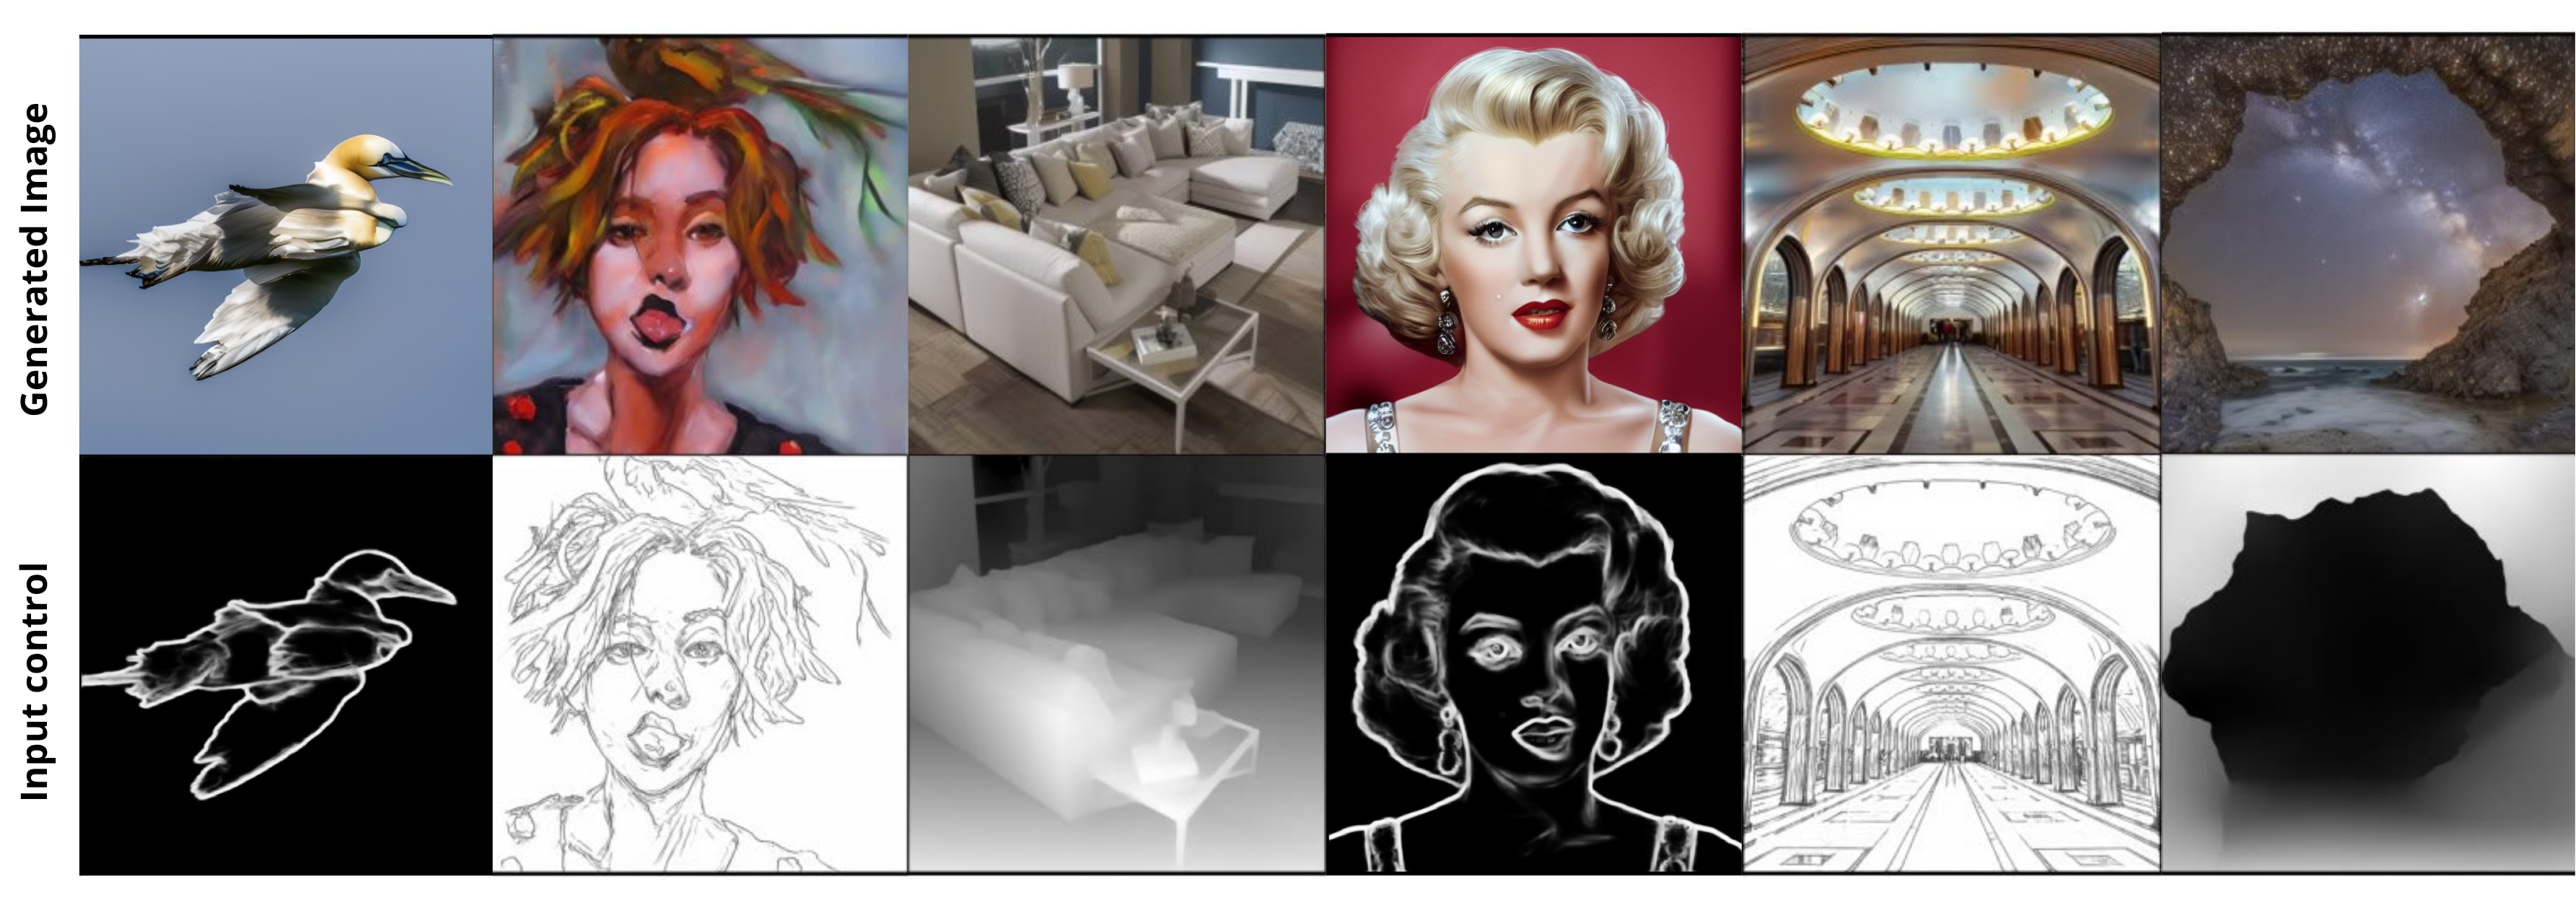

##  📚 Import Libraries amd clone repository

This block includes all necessary imports.

In [1]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers.schedulers import UniPCMultistepScheduler, DDIMScheduler
from PIL import Image
from transformers import DPTImageProcessor, DPTForDepthEstimation
import torchvision.transforms.functional as F
import os
import torch
import gc


In [12]:
#@title 📚 Load controlNet { display-mode: "form" }

# @markdown Model parameters
control_type = "hed"  # @param ["depth", "lineart", "hed"]
torch_dtype = "torch.float16"  # @param ["torch.float16", "torch.bfloat16", "torch.float32"]
device = 'cuda'   # @param ["cuda", "cpu"]
scheduler = 'unipc'   # @param ["unipc", "ddim"]

# Step 2: Download the entire folder using folder ID
folder_id = "1LAQ0iIT6YsIWg_rAf1gKXriKUPRrIajo"
output_dir = "weights"  # local directory to save files

dowload_id = {'depth': '12DmxpUXQTOw7L73kYU6yPTp1QlblgCh4',
              'hed': '1LAQ0iIT6YsIWg_rAf1gKXriKUPRrIajo',
              'lineart': '1_K9NlB4iqZOJMxKM8IYFY_AhNLZyYkYU'}

controlnet_mapping = {
    "depth": "weights/aligned_control_depth",
    "lineart": "weights/aligned_control_lineart",
    "hed": "weights/aligned_control_hed"
}


torch.cuda.empty_cache()
gc.collect()


controlnet_id = dowload_id[control_type]

if not os.path.exists(controlnet_mapping[control_type]):
  !gdown --id {controlnet_id}  --folder -O weights/




controlnet = ControlNetModel.from_pretrained(controlnet_mapping[control_type], torch_dtype=torch_dtype)

try:
  del pipe
except:
  pass

# Load Stable Diffusion pipeline
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch_dtype,
    safety_checker=None  # Optional: disable safety checker for faster inference
)

if scheduler == 'ddim':
    pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
else:
    pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# NOTE: assign a specific gpu_id is necessary, otherwise all models will be loaded on gpu 0
pipe.enable_model_cpu_offload()



Passed `torch_dtype` torch.float32 is not a `torch.dtype`. Defaulting to `torch.float32`.
The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to ControlNetModel, but are not expected and will be ignored. Please verify your config.json configuration file.
Passed `torch_dtype` torch.float32 is not a `torch.dtype`. Defaulting to `torch.float32`.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [14]:
#@title 📚 Run inference { display-mode: "form" }
# @markdown ### Inference Parameters

try:
  del images
except:
  pass

torch.cuda.empty_cache()
gc.collect()

Image_path = "/content/0_hed.png"                # @param {type:"string"}
prompt = "diver at the great white wall in fiji" # @param {type:"string"}

num_inference_steps = 20  # @param {type:"integer"}
guidance_scale = 7.5  # @param {type:"number"}
seed = 2  # @param {type:"integer"}


resolution = 512
image = Image.open(Image_path)


condition = image.convert('RGB').resize((resolution, resolution), Image.Resampling.BICUBIC)


generator = torch.Generator(device=device).manual_seed(seed)

images = pipe(
              prompt=prompt,
              image=condition,
              num_inference_steps=num_inference_steps,
              guidance_scale=guidance_scale,
              negative_prompt='worst quality, low quality',
              generator=generator).images


  0%|          | 0/20 [00:00<?, ?it/s]

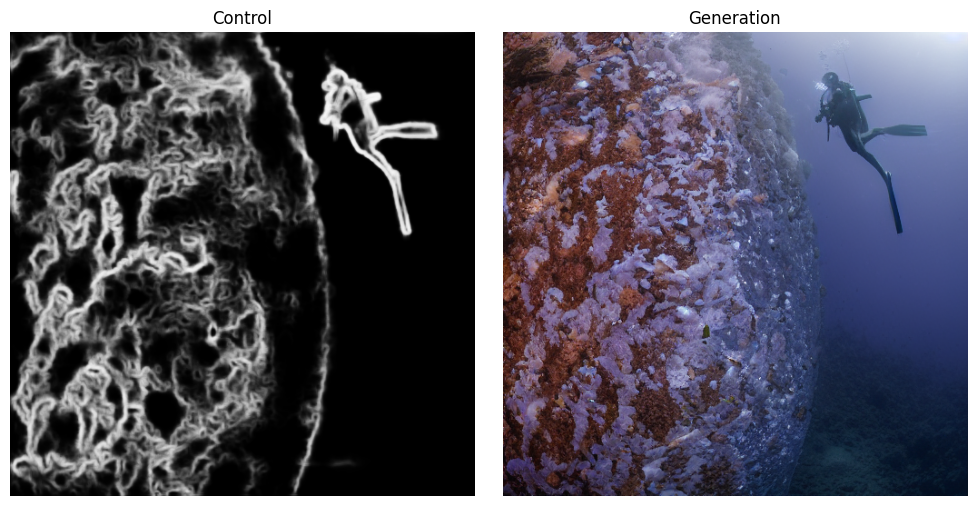

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))  # Adjust figure size if needed

plt.subplot(1, 2, 1)
plt.title("Control")
plt.imshow(condition)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Generation")
plt.imshow(images[0])
plt.axis("off")

plt.tight_layout()
plt.show()